![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

# HUMIDEX Heat stress analyses using Climate DT modeled data 2020-2040

Author: Dr. Alen Berta (CGI), Cesare Rossi (CGI)

Licence: MIT

Reference:
https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide

Notes:
This example is intended for hands-on learning and does not constitute a comprehensive climatic study. This notebook will showcase the time series point analyses for 2 cities in Croatia (Zagreb as representative of continental climate and Dubrovnik as representative of Mediterranean climate).


HUMIDEX describes how hot, humid weather feels to the average person. The Humidex combines the temperature and humidity into one number to reflect the perceived temperature. Because it takes into account the two most important factors that affect summer comfort, it can be a better measure of how stifling the air feels than either temperature or humidity alone. The Humidex is widely used in Canada. 

Classes are as follows:

- Little discomfort (from 20 to 30)

- Some discomfort (up to value 40)

- Great discomfort, avoid exertion (up to value 45)

- Dangerous, heat stroke possible (above value 45)

https://www.canada.ca/en/environment-climate-change/services/seasonal-weather-hazards/warm-season-weather-hazards.html#toc7

The data used here are based on SSP3 NEMO model, representing next to worst scenario modeled in Shared Socio-Economic Pathways (SSPs) predicting the highest population development and lowest GDP amongst the considered scenarios in the near future, with global mean temperature rising between 3.85 and 4.55 C until 2100. (more info and photo credit https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change/)

![images/SSP_models.png](images/SSP_models.png)

This notebook will provide the analyses relevant for detecting increased temperature stress due to climate change. The data used stem from Climate DT (https://destine.ecmwf.int/news/climate-change-adaptation-digital-twin-a-window-to-the-future-of-our-planet/) and will provide the calculation of some climate extreme indices (https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide).

Specifically, we will present the approach to:
 1) Calculate and count the days of increased heat stress per month based on HUMIDEX index
 2) Visualize the same index/indicator on a monthly level for the selected year

The equations to calculate heat stress indicators are adapted from https://github.com/schwings-clemens/CDS_heat_stress_indicators.

## Data access

<div style="border: 2px solid #28a745; background-color: #d4edda; padding: 10px; border-radius: 5px;">
  <strong>💡 Tip:</strong> Provide here your Destination Earth credentials. Ensure that you requested and obtained an access policy upgrade, which is necessary to read the Climate DT data of this example. See <a href="https://platform.destine.eu/access-policy-upgrade/">https://platform.destine.eu/access-policy-upgrade</a>.
</div>

In [1]:
%%capture cap
%run ./cacheb-authentication.py

Username:  cesare.rossi@cgi.com
Password:  ········


In [2]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

### Data loading

In [3]:
import xarray as xr
import pandas as pd
import os
import umidex_utils

In [4]:
data = xr.open_dataset(
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
    storage_options={"client_kwargs":{"trust_env":"true"}},
    chunks={},
    engine="zarr",
)

In [5]:
data

<xarray.Dataset> Size: 800TB
Dimensions:           (time: 175320, latitude: 4096, longitude: 8193)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 33kB -90.0 -89.96 -89.91 ... 89.96 90.0
  * longitude         (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:...
Data variables: (12/34)
    blh               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    chnk              (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    d2m               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    e                 (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ewss              (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    hcc               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ...                ...
    tp                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate            (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tsr               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ttr               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Load 2m temperature, dew temperature and pressure values.

In [6]:
t2m = data.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"

d2m = data.d2m.astype("float32") - 273.15
d2m.attrs["units"] = "C"

Lat/lon definition for point time series.

In [7]:
zagreb_lat_lon=(45.8150,15.9819)
dubrovnik_lat_lon=(43.5147,16.4435)

Select your year of interest between 2020 and 2040.

In [8]:
year_of_interest = "2035"

Decide whether you would like to perform a full analysis between 2020 and 2040.

In [9]:
full_2020_2040_analysis = False # If True, the analysis is performed against the whole period, then comparing it to the year_of_interest

<div style="border: 2px solid #f5c518; background-color: #fff3cd; padding: 10px; border-radius: 5px;">
  <strong>⚠️ Warning:</strong> The computation time for one city/pixel/point for 2020-2040 might require 1.5 hours or more. Therefore, <b>for initial experiments, we suggest keeping the variable full_2020_2040_analysis set to False.</b>
</div>

Prepare the input data for calculation.

In [10]:
# Select the data for Zagreb
t2m_zagreb = t2m.sel(latitude=zagreb_lat_lon[0], longitude=zagreb_lat_lon[1], method='nearest')
d2m_zagreb = d2m.sel(latitude=zagreb_lat_lon[0], longitude=zagreb_lat_lon[1], method='nearest')

# Select the data for Dubrovnik
t2m_dubrovnik = t2m.sel(latitude=dubrovnik_lat_lon[0], longitude=dubrovnik_lat_lon[1], method='nearest')
d2m_dubrovnik = d2m.sel(latitude=dubrovnik_lat_lon[0], longitude=dubrovnik_lat_lon[1], method='nearest')

if not full_2020_2040_analysis:
    # Subset the data for a given year
    t2m_zagreb = t2m_zagreb.sel(time=year_of_interest)
    d2m_zagreb = d2m_zagreb.sel(time=year_of_interest)

    t2m_dubrovnik = t2m_dubrovnik.sel(time=year_of_interest)
    d2m_dubrovnik = d2m_dubrovnik.sel(time=year_of_interest)

In [11]:
# xarray metadata for Zagreb  
print(f"{t2m_zagreb}\n")
print(f"{d2m_zagreb}\n")

<xarray.DataArray 't2m' (time: 8760)> Size: 35kB
dask.array<getitem, shape=(8760,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
    entireAtmosphere  float64 8B ...
    latitude          float64 8B 45.82
    longitude         float64 8B 16.0
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 70kB 2035-01-01 ... 2035-12-31T23...
Attributes:
    units:    C

<xarray.DataArray 'd2m' (time: 8760)> Size: 35kB
dask.array<getitem, shape=(8760,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
    entireAtmosphere  float64 8B ...
    latitude          float64 8B 45.82
    longitude         float64 8B 16.0
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 70kB 2035-01-01 ... 2035-12-31T23...
Attributes:
    units:    C



### HUMIDEX calculation

The following cells will:

1) Calculate HUMIDEX based on temperature and dew point on preselected datasets (in this case Zagreb and Dubrovnik between 2020 and 2040),
2) Detect the maximum value of index within the day
3) Categorize this value into HUMIDEX categories
4) Count unique categories per month
5) Calculate the mean and standard deviation for each month between 2020-2040 (only if the `full_2020_2040_analysis` is `True`),
8) Plot per HUMIDEX category the values for selected year as bars, the average from 2020-2040 as points (meaningful only if the `full_2020_2040_analysis` is `True`), st.dev from 2020-2040 as lines (meaningful only if the `full_2020_2040_analysis` is `True`) 

In [12]:
HU_zagreb = umidex_utils.Humidex(t2m_zagreb, d2m_zagreb)
HU_dubrovnik = umidex_utils.Humidex(t2m_dubrovnik, d2m_dubrovnik)

In [13]:
HU_zagreb_daily_max = HU_zagreb.coarsen(time=24, boundary='trim').max()
HU_dubrovnik_daily_max = HU_dubrovnik.coarsen(time=24, boundary='trim').max()

In [14]:
# Apply categorization to the datasets
HU_zagreb_daily_max_category = umidex_utils.apply_categorization(HU_zagreb_daily_max)
HU_dubrovnik_daily_max_category = umidex_utils.apply_categorization(HU_dubrovnik_daily_max)

<div style="border: 2px solid #f5c518; background-color: #fff3cd; padding: 10px; border-radius: 5px;">
  <strong>⚠️ Warning:</strong>The following cell usually takes <b>5 minutes</b> for each city/pixel/point. <b>If the variable full_2020_2040_analysis is set to True it might require 1.5 hour or more for one city/pixel/point.</b>
</div>

In [15]:
# Perform monthly unique counts for Zagreb and Dubrovnik
%time HU_zagreb_monthly_unique_counts = umidex_utils.monthly_unique_counts(HU_zagreb_daily_max_category)
%time HU_dubrovnik_monthly_unique_counts = umidex_utils.monthly_unique_counts(HU_dubrovnik_daily_max_category)

CPU times: user 1min 23s, sys: 35.6 s, total: 1min 59s
Wall time: 4min 2s
CPU times: user 1min 23s, sys: 37.2 s, total: 2min
Wall time: 4min 9s


In [16]:
# Pivot the DataFrame to have separate columns for each class
zagreb_df_pivot = HU_zagreb_monthly_unique_counts.pivot(index='month', columns='group', values='counts').reset_index()
dubrovnik_df_pivot = HU_dubrovnik_monthly_unique_counts.pivot(index='month', columns='group', values='counts').reset_index()

In [17]:
# Save the results - this is useful in case you would like to skip to the computation step above
csv_directory = "csv"
if not os.path.exists(csv_directory):
    os.makedirs(csv_directory)
    
output_file = f'{csv_directory}/HU_zagreb_monthly_unique_counts.csv'
zagreb_df_pivot.to_csv(output_file, index=False)

output_file = f'{csv_directory}/HU_dubrovnik_monthly_unique_counts.csv'
dubrovnik_df_pivot.to_csv(output_file, index=False)

In [18]:
# Read the data from CSV files
HU_dubrovnik_monthly_counts = pd.read_csv(f'{csv_directory}/HU_dubrovnik_monthly_unique_counts.csv', index_col=0, parse_dates=True)
HU_zagreb_monthly_counts = pd.read_csv(f'{csv_directory}/HU_zagreb_monthly_unique_counts.csv', index_col=0, parse_dates=True)

<div style="border: 2px solid #28a745; background-color: #d4edda; padding: 10px; border-radius: 5px;">
  <strong>💡 Tip:</strong> In the graphs below, the average and standard deviation value for the period 2020-2040 are meaningful <b>only if the variable full_2020_2040_analysis was True</b>.</a>
</div>

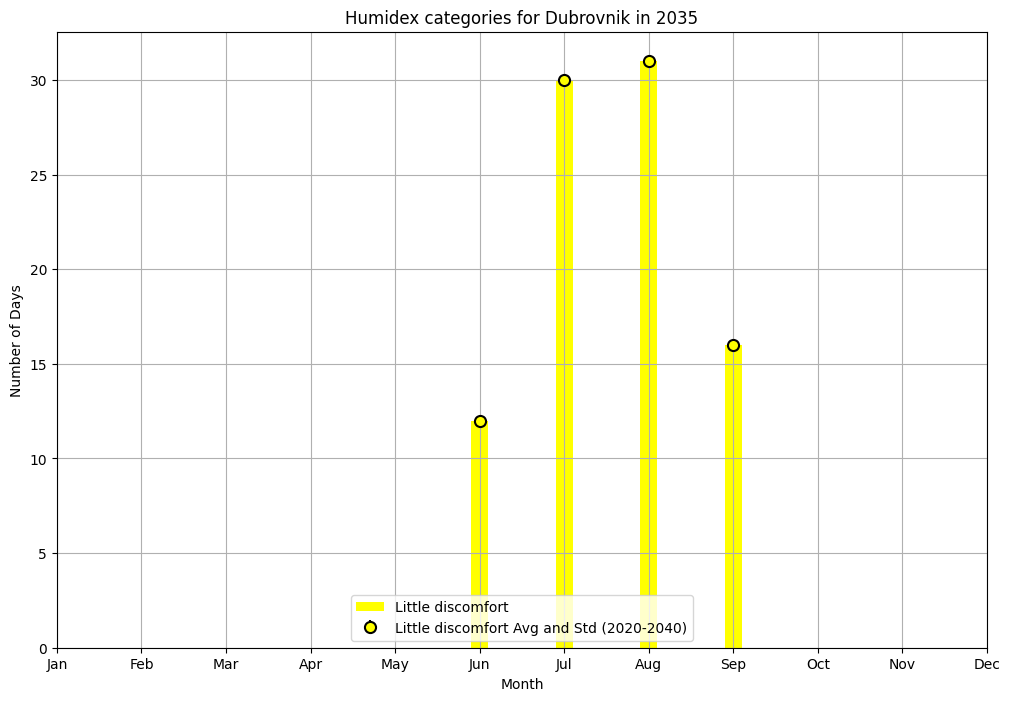

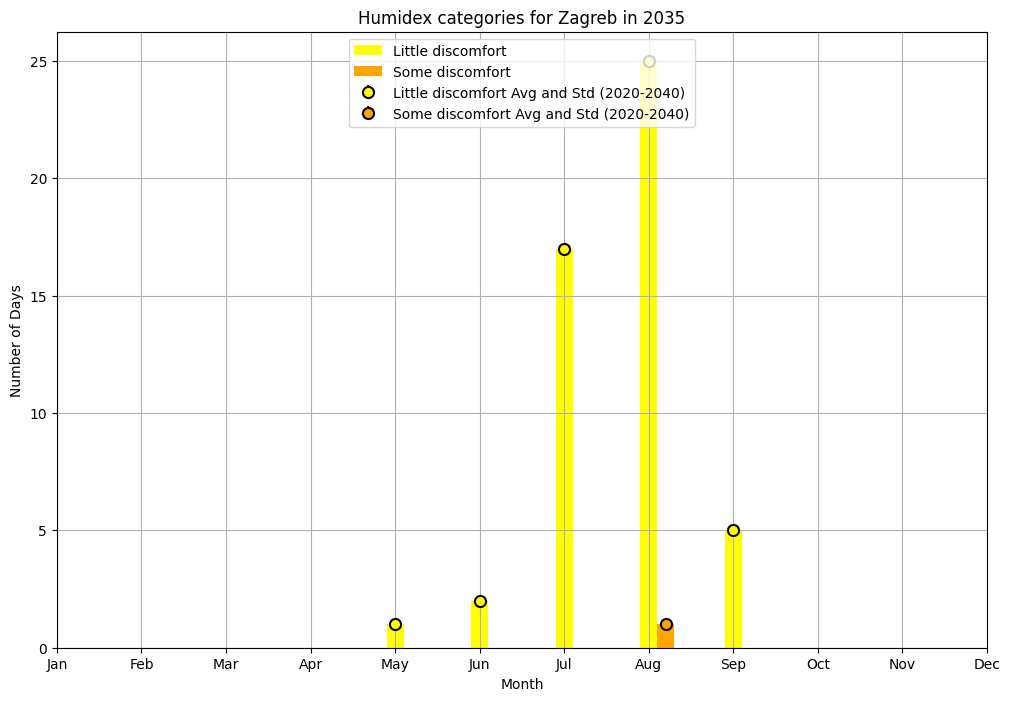

In [19]:
# Calculate the average and standard deviation per month for each category for the whole data range
HU_dubrovnik_monthly_stats = HU_dubrovnik_monthly_counts.groupby(HU_dubrovnik_monthly_counts.index.month).agg(['mean', 'std'])
HU_zagreb_monthly_stats = HU_zagreb_monthly_counts.groupby(HU_zagreb_monthly_counts.index.month).agg(['mean', 'std'])

# Select the data for the specified year
HU_dubrovnik_yoi = HU_dubrovnik_monthly_counts.loc[str(year_of_interest)]
HU_zagreb_yoi = HU_zagreb_monthly_counts.loc[str(year_of_interest)]

# Plot for Dubrovnik
umidex_utils.plot_heat_index_categories(HU_dubrovnik_yoi, HU_dubrovnik_monthly_stats, "Dubrovnik", year_of_interest)

# Plot for Zagreb
umidex_utils.plot_heat_index_categories(HU_zagreb_yoi, HU_zagreb_monthly_stats, "Zagreb", year_of_interest)